In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import cv2
import numpy as np
import SimpleITK as sikt
from PIL import Image

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
image_path = '../data/ID_c9d6fdc6_ID_7f09be285d.png'
label_path = '../data/ID_c9d6fdc6_ID_7f09be285d-ich_seg.png'

In [5]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 12

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

def print_info(img, label):
    print(f"Image shape: {img.shape}, Label shape: {label.shape}")

In [6]:
image = cv2.imread(image_path)
label = np.asarray(Image.open(label_path))

Image shape: (512, 512, 3), Label shape: (512, 512)


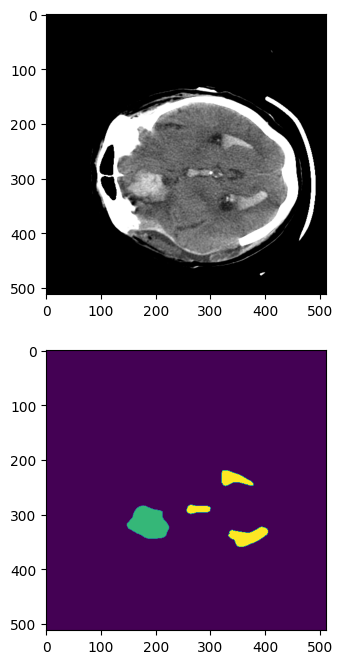

In [7]:
print_info(image, label)
visualize(image, label)

## MotionBlur

`MotionBlur` 是一种模拟 **运动模糊（Motion Blur）** 的数据增强方法，主要用来模拟相机在拍摄物体时由于运动导致的模糊效果。这种模糊可以沿一定方向（线性）传播，类似于物体在相机快门打开时发生移动。

-   **核心思想**：使用一个 **线性卷积核（卷积矩阵）** 对图像进行模糊。卷积核沿一个方向（由 `angle` 决定）展开，核的长度（由 `kernel_size` 决定）控制模糊程度。

-   **效果**：在增强后的图片中，物体边缘会出现拖影，增强模型对运动模糊的鲁棒性。

### 使用场景 

-   **自动驾驶与交通监控**：车辆、行人、交通标志等图像中可能因为相机抖动或目标运动而模糊。

-   **目标检测与分类**：提高模型对实际场景下拍摄图像的适应能力。

-   **视频帧预测**：视频中帧与帧之间存在运动模糊，通过此增强可提高模型泛化性能。

-   **任何需要增加运动模糊鲁棒性的任务**。

### 参数解析 

| 参数              | 类型                       | 默认值        | 含义                                                         |
| ----------------- | -------------------------- | ------------- | ------------------------------------------------------------ |
| `blur_limit`      | `int` 或 `tuple[int, int]` | `(3, 7)`      | 模糊核的尺寸范围。若为整数，表示从 `[3, blur_limit]` 中随机选择；若为元组，表示从 `[min, max]` 中随机选择。越大越模糊。必须 ≥ 3 且为奇数。 |
| `angle_range`     | `tuple[float, float]`      | `(0, 360)`    | 模糊角度范围（单位：度），控制模糊方向。0°：水平，90°：垂直，45°/135°：对角线等。 |
| `direction_range` | `tuple[float, float]`      | `(-1.0, 1.0)` | 控制模糊线的方向偏移。-1.0：只向后模糊；0.0：两端均模糊；1.0：只向前模糊。 |
| `allow_shifted`   | `bool`                     | `True`        | 是否允许模糊核中心偏移（生成非对称模糊效果）。               |
| `p`               | `float`                    | `0.5`         | 应用该增强的概率。                                           |

Image shape: (512, 512, 3), Label shape: (512, 512)


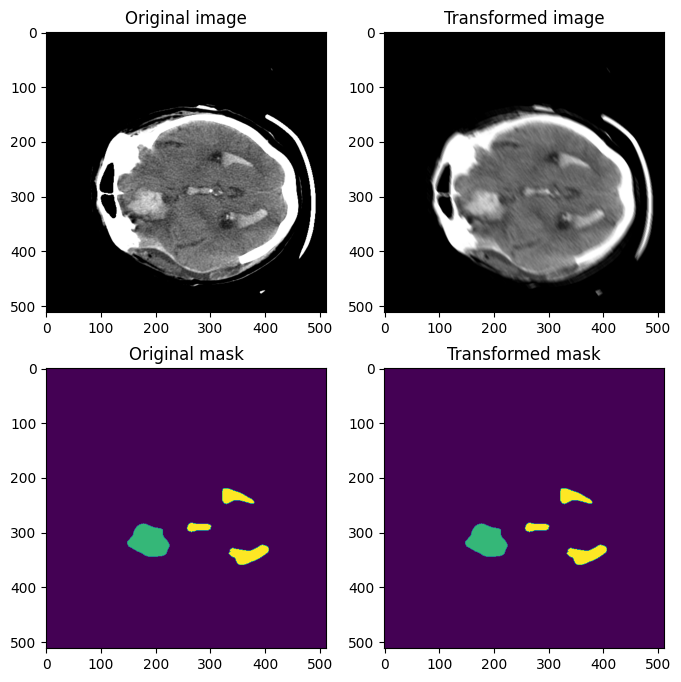

In [9]:
transform = A.Compose([
    A.MotionBlur(blur_limit=(5, 15), p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## MedianBlur

`MedianBlur` 是一种中值滤波（Median Filtering）技术。其核心思想是：

-   对于图像中的每一个像素，将其周围一定范围内的像素值排序，取中间值（中位数）作为该像素的新值。

-   与均值滤波（`AverageBlur`）不同，`MedianBlur` 对边缘和噪声有更好的保留能力，因为它不会受到极端异常值（如椒盐噪声）的影响。

✅ **核心优势：**

-   有效去除椒盐噪声。

-   对边缘保留效果比均值滤波更好。

### 使用场景 

-   **图像去噪：** 尤其对椒盐噪声（salt-and-pepper noise）有良好抑制效果。

-   **数据增强：** 在深度学习中，为了增加数据的多样性，使用中值滤波对图像进行模糊处理，帮助模型学习更鲁棒的特征。

-   **边缘保护降噪：** 在需要降噪但保持边缘的任务中（如医学图像处理），中值滤波是常用的预处理方法。

### 参数解析 

| 参数         | 类型                  | 说明                                                         |
| ------------ | --------------------- | ------------------------------------------------------------ |
| `blur_limit` | `int` or `(int, int)` | 滤波核的大小范围（必须是奇数）。如果是单个 `int`，则固定核大小；如果是 `(min, max)`，则随机选择一个奇数核大小，范围在 `[min, max]` 内。较大的核会导致更强的模糊效果。 |
| `p`          | `float`               | 应用该变换的概率。取值范围 `[0,1]`，默认 `0.5`。             |

Image shape: (512, 512, 3), Label shape: (512, 512)


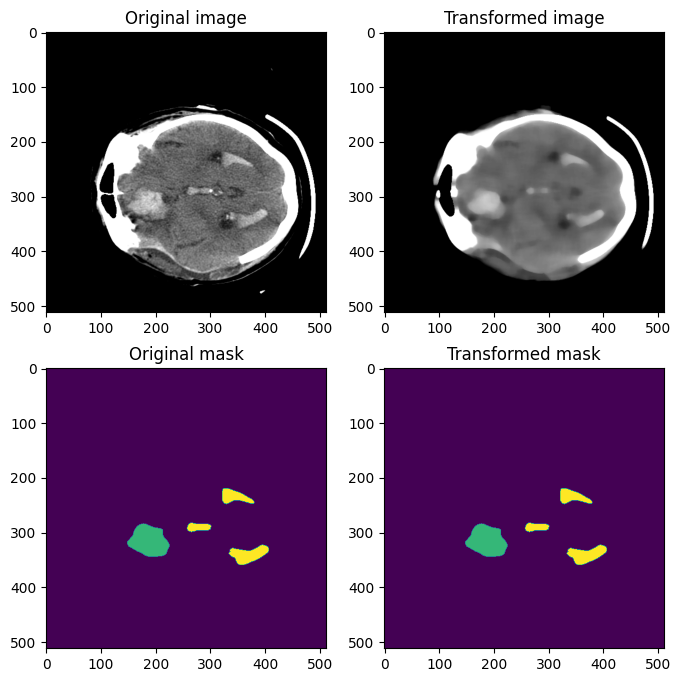

In [10]:
transform = A.Compose([
    A.MedianBlur(blur_limit=(5, 15), p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## GaussianBlur

`GaussianBlur` 是一种 **高斯模糊** 操作，其核心是利用 **高斯核** 对图像进行卷积处理。  
高斯模糊的公式：
$$
G(x, y) = \frac{1}{2\pi \sigma^2} e^{- \frac{x^2 + y^2}{2\sigma^2}}
$$

其中：

-   $(x, y)$：卷积核中像素点相对中心的坐标

-   $\sigma$：标准差，控制模糊程度。值越大，模糊越强。

高斯核对图像进行平滑处理，消除高频噪声，使图像看起来更加模糊和平滑。

### 使用场景 

-   **降噪**：平滑图像，降低噪声对模型的影响  

-   **数据增强**：模拟摄像头对焦模糊、运动模糊等场景，使模型更鲁棒 

-   **特征消融**：测试模型在局部或全局模糊情况下的表现

### 参数解析 

| 参数             | 类型                             | 默认值     | 说明                                                         |
| ---------------- | -------------------------------- | ---------- | ------------------------------------------------------------ |
| **sigma\_limit** | `tuple[float, float]` 或 `float` | (0.5, 3.0) | 控制高斯核的标准差（σ）。<br/>\- 如果是单个浮点数：σ在 (0, value) 内随机选取。<br/>\- 如果是元组 (min, max)：σ在 [min, max] 内随机选取。<br/>必须 ≥ 0。 |
| **blur\_limit**  | `tuple[int, int]` 或 `int`       | 0          | 控制高斯核的大小。<br/>\- 如果是单个整数：核大小在 (0, value) 内随机选取。<br/>\- 如果是元组 (min, max)：核大小在 [min, max] 内随机选取。<br/>必须为奇数或 0。如果为 0，核大小将根据 σ 自动计算（`int(sigma * 3.5) * 2 + 1`），与 PIL 实现保持一致。 |
| **p**            | `float`                          | 0.5        | 应用此变换的概率。                                           |

Image shape: (512, 512, 3), Label shape: (512, 512)


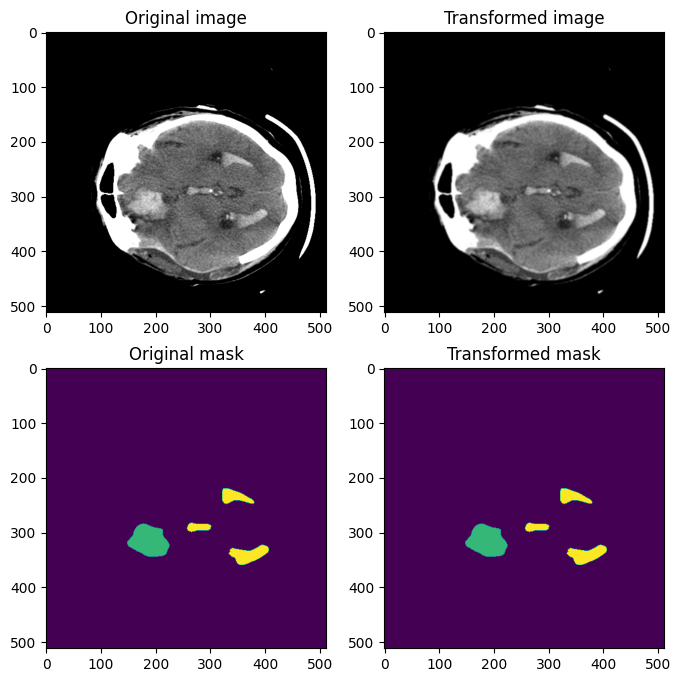

In [12]:
transform = A.Compose([
    A.GaussianBlur(blur_limit=(3, 5), sigma_limit=(0.1, 2.0), p=1)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## GlassBlur

`GlassBlur` 模拟了图像通过半透明玻璃或者毛玻璃观察时产生的效果。其工作原理主要分两步：

1️⃣ **高斯模糊 (Gaussian Blur)**：  
对图像进行高斯模糊，柔化细节，模拟图像在玻璃表面散射的初步模糊。

2️⃣ **局部扭曲 (Localized Pixel Swaps)**：  
在图像中以网格为单位（格子大小由 `grid` 参数控制），随机交换某些网格块之间的像素，模拟玻璃上的随机光线折射和散射。这个过程强化了玻璃的“扭曲感”。

这种两步过程（高斯模糊 + 局部扰动）与单纯的模糊相比，更加贴近真实场景中的毛玻璃效果。

### 使用场景 

-   **数据增强**：用于扩充训练集，尤其是在物体遮挡、模糊场景下训练模型（如目标检测、分割）。

-   **鲁棒性提升**：让模型适应不同清晰度和可见度条件（如安防、自动驾驶、低照度场景）。

-   **模糊测试**：测试模型在模糊图像上的性能，评估其对图像质量变化的容忍度。

### 参数解析 

| 参数           | 类型                       | 说明                                                         |
| -------------- | -------------------------- | ------------------------------------------------------------ |
| **sigma**      | `float`                    | 高斯核的标准差，值越大模糊效果越强。必须为非负数。默认值：`0.7` |
| **max\_delta** | `int`                      | 像素交换的最大距离（单位：像素）。值越大扭曲感越强。必须为正整数。默认值：`4` |
| **iterations** | `int`                      | 应用玻璃模糊效果的迭代次数。迭代越多，效果越强，计算时间也越长。必须为正整数。默认值：`2` |
| **mode**       | `Literal["fast", "exact"]` | 计算模式：`"fast"` 提供更快但可能不够精确的计算；`"exact"` 更慢但更精确。默认值：`"fast"` |
| **p**          | `float`                    | 应用概率（范围 `[0,1]`）。值越大，越可能应用此增强。默认值：`0.5` |

Image shape: (512, 512, 3), Label shape: (512, 512)


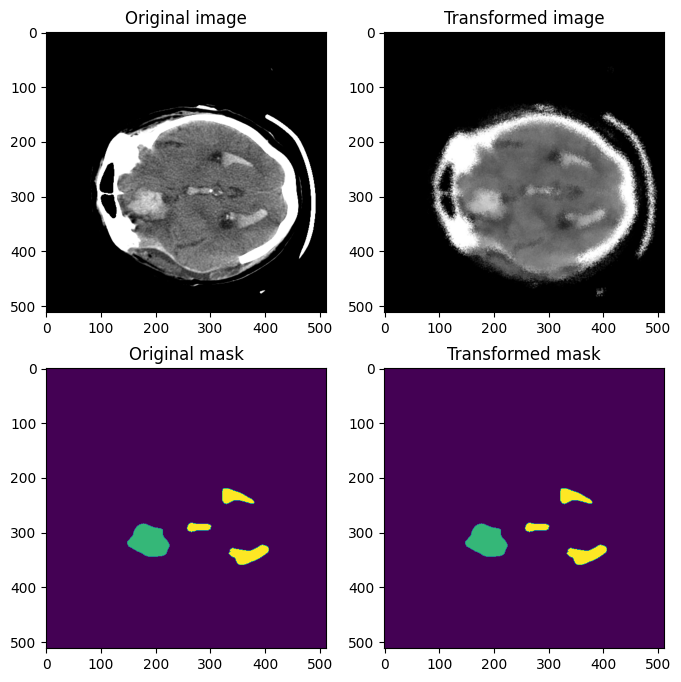

In [13]:
transform = A.Compose([
    A.GlassBlur(sigma=0.7, max_delta=4, iterations=2, p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## AdvancedBlur

`AdvancedBlur` 是 Albumentations 中的一种模糊增强方式，主要目的是生成更加真实和多样化的模糊效果。其核心思想是结合多种模糊内核（内核形状、大小、方向）生成 **非均匀、高阶的模糊效果**，以模拟现实中因运动、对焦不准、镜头污迹等因素引起的图像模糊。

其原理包括：

-   随机生成不同形状（椭圆、线性、非对称）的卷积核；

-   内核的尺寸、旋转角度、偏移量可以随机变化；

-   对输入图像进行卷积操作，达到模糊效果；

-   与普通高斯模糊（如 `GaussianBlur`）相比，`AdvancedBlur` 生成的模糊更具复杂性，能更好地拟合复杂的模糊模式。

它底层实现中调用了 `kornia` 的 `motion_blur` 和 `defocus_blur` 方法，以保证高效且效果自然。

### 使用场景 

-   **增强训练数据多样性**：在训练图像分类、目标检测、语义分割等任务中，加入高阶模糊增强，以增强模型对模糊图像的鲁棒性。

-   **低光/运动模糊下的鲁棒性提升**：例如车牌识别、监控、无人驾驶场景下，图像常因运动模糊而失真，使用 `AdvancedBlur` 可增强模型对这类图像的适应能力。

-   **生成更加真实的模糊样本**：相比单一高斯模糊，`AdvancedBlur` 的复杂模糊可以模拟真实世界的摄像机抖动、运动模糊等复杂情况

### 参数解析 

| 参数            | 类型                             | 默认值         | 解释                                                         |
| --------------- | -------------------------------- | -------------- | ------------------------------------------------------------ |
| `blur_limit`    | `tuple[int, int]` 或 `int`       | `(3, 7)`       | 控制模糊核的尺寸。单个整数时范围为 `(3, limit)`，必须是奇数且 ≥ 3。值越大模糊越强。 |
| `sigma_x_limit` | `tuple[float, float]` 或 `float` | `(0.2, 1.0)`   | 控制 x 方向模糊扩散程度。值越大，模糊越强。单个浮点数时范围为 `(0, limit)`。 |
| `sigma_y_limit` | `tuple[float, float]` 或 `float` | `(0.2, 1.0)`   | 控制 y 方向模糊扩散程度。与 `sigma_x_limit` 类似。           |
| `rotate_limit`  | `tuple[int, int]` 或 `int`       | `(-90, 90)`    | 控制模糊核的随机旋转角度范围（单位度）。单个整数时范围为 `(-limit, limit)`。 |
| `beta_limit`    | `tuple[float, float]` 或 `float` | `(0.5, 8.0)`   | 控制核的形状。β=1 为高斯分布，β<1 更类似均匀分布，β>1 则更加集中（尖锐）模糊。 |
| `noise_limit`   | `tuple[float, float]` 或 `float` | `(0.75, 1.25)` | 控制对模糊核的乘性噪声强度。接近 1 时核接近原样，偏离 1 时引入更多变化。 |
| `p`             | `float`                          | `0.5`          | 应用该变换的概率。                                           |

Image shape: (512, 512, 3), Label shape: (512, 512)


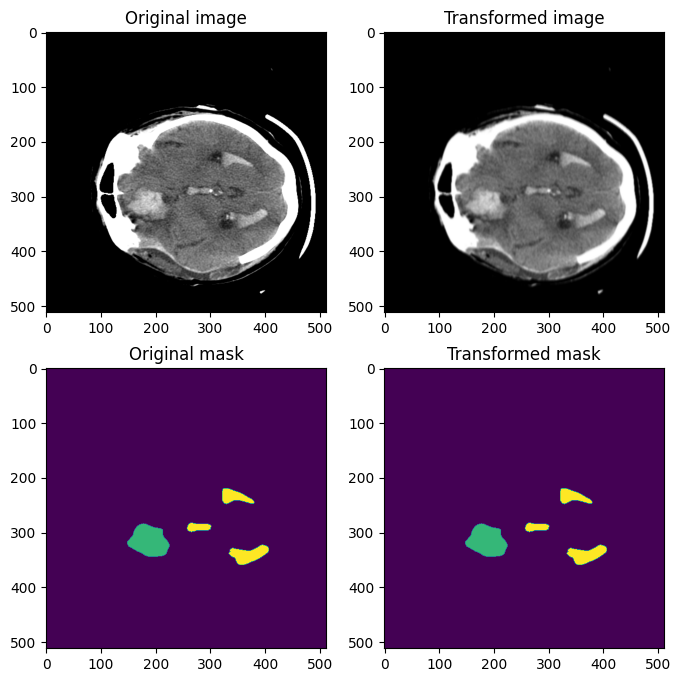

In [15]:
transform = A.Compose([
    A.AdvancedBlur(
        blur_limit=(3,7), 
        sigma_x_limit=(0.1,2.0), 
        sigma_y_limit=(0.1,2.0),
        rotate_limit=(-30,30), 
        beta_limit=(0.5,5.0), 
        noise_limit=(0.01, 0.05), 
        p=1.0),
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## Defocus

**`Defocus`** 是一种模糊（Blur）类型的图像增强操作，其本质是模拟 **镜头失焦（Defocus blur）** 效果。  
这种失焦模糊与高斯模糊、运动模糊不同，它更接近实际相机在未聚焦情况下产生的效果。其原理是通过对图像进行 **圆形卷积核（disk kernel）** 模糊，模拟真实的相机失焦点扩散函数（PSF）。

具体过程：

1.  生成一个半径为 `radius` 的 **圆形卷积核（disk kernel）**。

2.  对图像进行卷积操作（或用快速傅里叶变换实现）以实现模糊效果。

3.  可以调整 **模糊半径** 和 **模糊方向性** 来控制模糊强度和效果。

这种模糊比简单的高斯核更接近真实失焦镜头产生的光学效果，尤其在模拟背景虚化、深度感增强时非常有效。

### 使用场景 

-   **图像增强和数据扩增**：在训练深度学习模型（如分类、检测、分割）时，通过加入失焦模糊增强模型对模糊图像的鲁棒性。

-   **模拟拍摄场景**：模拟相机拍摄中因对焦不准、景深限制等原因导致的模糊，适用于自动驾驶、安防监控等任务。

-   **背景虚化模拟**：在人像或背景虚化的应用中，Defocus 模拟自然的镜头虚化效果。

-   **缺陷检测和容错性测试**：帮助训练模型对焦点外目标（模糊）保持较好识别能力。

### 参数解析 

| 参数名       | 类型                             | 说明                                                         | 默认值       |
| ------------ | -------------------------------- | ------------------------------------------------------------ | ------------ |
| `radius`     | `tuple[int, int]` 或 `int`       | 失焦模糊的半径范围。若为单个 `int`，则范围为 `[1, radius]`。值越大，模糊效果越强。 | `(3, 10)`    |
| `alias_blur` | `tuple[float, float]` 或 `float` | 在主 defocus blur 之后应用的高斯模糊标准差范围，用于减少混叠伪影。若为单个 `float`，则范围为 `(0, alias_blur)`。值越大，效果越平滑，混叠越少。 | `(0.1, 0.5)` |
| `p`          | `float`                          | 应用此变换的概率，范围 `[0, 1]`。                            | `0.5`        |

Image shape: (512, 512, 3), Label shape: (512, 512)


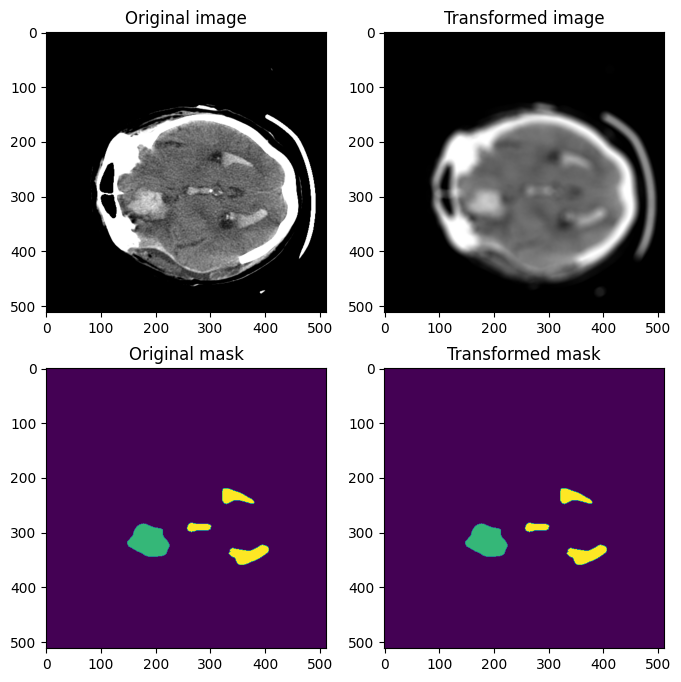

In [16]:
transform = A.Compose([
    A.Defocus(radius=(5, 15), p=1.0)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)

## ZoomBlur

`ZoomBlur` 是一种图像模糊技术，模拟通过相机镜头在不同缩放（放大或缩小）程度下捕捉图像时产生的模糊效果。它会对图像的像素沿着中心点向外进行“拉伸”或“缩放”，然后将这些缩放后的图像以一定权重混合，形成模糊效果。

具体来说，ZoomBlur 通过以下步骤实现：

-   选定一个中心点（默认为图像中心）。

-   对原始图像进行若干次缩放，缩放因子逐渐变化（一般是从1开始，放大或缩小一定比例）。

-   将这些缩放后的图像按权重叠加，形成类似于“径向模糊”的效果。

-   模糊效果呈现为图像中朝向中心点的放大或缩小模糊线条，类似运动模糊但焦点固定在中心。

这种模糊不同于普通的高斯模糊或均值模糊，它保留了图像的结构方向性，使得图像看起来像是在中心点处进行放射状“拉伸”模糊。

### 使用场景 

-   **增强模型对变焦模糊的鲁棒性** ：在现实拍摄中，手抖、焦距调整等可能引入类似 ZoomBlur 的模糊。通过训练时加入此增强，可以让模型更稳定地处理此类模糊图像。

-   **模拟运动或缩放过程中的模糊** ：用于检测或识别任务中，模拟目标缩放变焦带来的画面模糊，提升模型泛化能力。

-   **艺术风格和图像生成** ：用于图像风格化，制作有视觉冲击的模糊特效。

-   **数据增强** ：用于提高视觉模型对图像细节缺失、失焦等情况的容忍度，特别适合目标检测、图像分类、语义分割等任务。

### 参数解析 

| 参数名       | 类型                    | 默认值       | 说明                                                         |
| ------------ | ----------------------- | ------------ | ------------------------------------------------------------ |
| max\_factor  | float 或 (float, float) | (1, 1.31)    | 模糊最大缩放因子的范围。如果是单个 float，则范围为 (1, max\_factor)。所有值必须大于1。 |
| step\_factor | float 或 (float, float) | (0.01, 0.03) | 缩放因子递增步长范围，用于生成缩放序列。如果是单个 float，则作为 np.arange 的步长。所有值需为正。 |
| p            | float                   | 0.5          | 该变换被应用的概率，范围 0-1。                               |

Image shape: (512, 512, 3), Label shape: (512, 512)


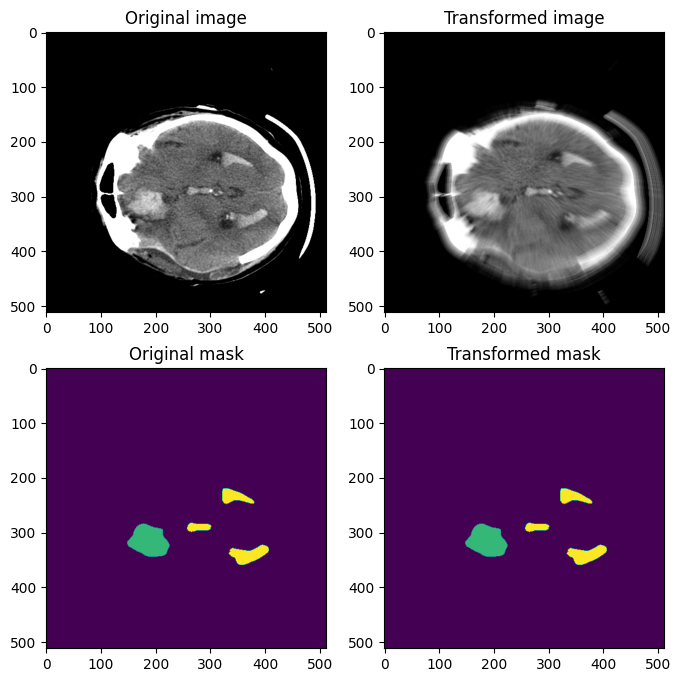

In [19]:
transform = A.Compose([
    A.ZoomBlur(
    max_factor=1.1,
    p=1,
)
])
transformed = transform(image=image, mask=label)
aug_image = transformed['image']
aug_mask = transformed['mask']
print_info(aug_image, aug_mask)
visualize(aug_image, aug_mask, image, label)